In [121]:
import os
import numpy as np
import pandas as pd
import pickle
import random
import warnings
from copy import deepcopy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import nltk
from gensim.models import Word2Vec

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

In [2]:
df = pd.read_csv('../data/processed_essays.csv')
df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cleaned_tokenize_text,corrected_text,...,num_mistakes,lemmatized_text,sent_count,sent_len,word_count,noun_count,verb_count,adjective_count,adverb_count,score_category
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,think students would benefit learning home cha...,think students would benefit learning home cha...,...,0,think student would benefit learn home change ...,18,14,261,54,25,24,6,medium
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,problem change let best matter happening chang...,problem change let best matter happening chang...,...,0,problem change let best matter happen change m...,14,38,533,102,51,38,9,low
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,dear principal change school policy grade aver...,dear principal change school policy grade aver...,...,0,dear principal change school policy grade aver...,19,16,320,56,20,30,5,medium
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,best time life become agree greatest accomplis...,best time life become agree greatest accomplis...,...,0,best time life become agree great accomplishme...,36,20,728,106,73,62,22,high
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act kindness impact people change people...,small act kindness impact people change people...,...,7,small act kindness impact people change people...,3,78,234,58,21,18,5,medium


In [3]:
target_columns = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
drop_columns = ["text_id", "full_text", "cleaned_tokenize_text", "corrected_text", "mistakes",
                "corrected_words", "score_category"]
feature_columns = ["num_mistakes", "sent_count", "sent_len", "word_count", "noun_count", "verb_count",
                   "adjective_count", "adverb_count"]
y = df[target_columns].copy()
df = df.drop(drop_columns + target_columns, axis=1)
df = df[["lemmatized_text"] + feature_columns]
df.head()

,lemmatized_text,num_mistakes,sent_count,sent_len,word_count,noun_count,verb_count,adjective_count,adverb_count
0,think student would benefit learn home change ...,0,18,14,261,54,25,24,6
1,problem change let best matter happen change m...,0,14,38,533,102,51,38,9
2,dear principal change school policy grade aver...,0,19,16,320,56,20,30,5
3,best time life become agree great accomplishme...,0,36,20,728,106,73,62,22
4,small act kindness impact people change people...,7,3,78,234,58,21,18,5


In [4]:
y.head()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.5,3.5,3.0,3.0,4.0,3.0
1,2.5,2.5,3.0,2.0,2.0,2.5
2,3.0,3.5,3.0,3.0,3.0,2.5
3,4.5,4.5,4.5,4.5,4.0,5.0
4,2.5,3.0,3.0,3.0,2.5,2.5


In [19]:
def token_to_vector(corpus, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for c in corpus:
        vectors = []
        for token in c:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)  # Take the mean since we need a 2D array instead of 3D
            features.append(avg_vec)
        else:
            features.append(np.zeros(model.vector_size))
    return np.array(features)

In [13]:
def featurize_text(df, column="lemmatized_text", method="CountVectorizer"):
    if method == "CountVectorizer":
        model = CountVectorizer()
    elif method == "Tfidf-1gram":
        model = TfidfVectorizer(ngram_range=(1, 1), min_df=10)
    elif method == "Tfidf-2gram":
        model = TfidfVectorizer(ngram_range=(1, 2), min_df=10)
    elif method == "Word2Vec":
        tokens = df[column].apply(lambda x: x.split())
        model = Word2Vec(sentences=tokens, vector_size=100, workers=12, seed=SEED)
        X = token_to_vector(tokens, model)
        X = pd.DataFrame(data=X, columns=[f"f{i+1}" for i in range(X.shape[1])])
    else:
        raise ValueError("Choose the value of the 'method' argument from 'CountVectorizer', 'Tfidf-1gram', 'Tfidf-2gram', or 'Word2Vec'")
    
    if method != "Word2Vec":
        X = model.fit_transform(df[column])
        X = pd.DataFrame(X.toarray(), columns=model.get_feature_names_out())
    
    X = pd.concat([X, df[feature_columns]], axis=1)
    return X, model

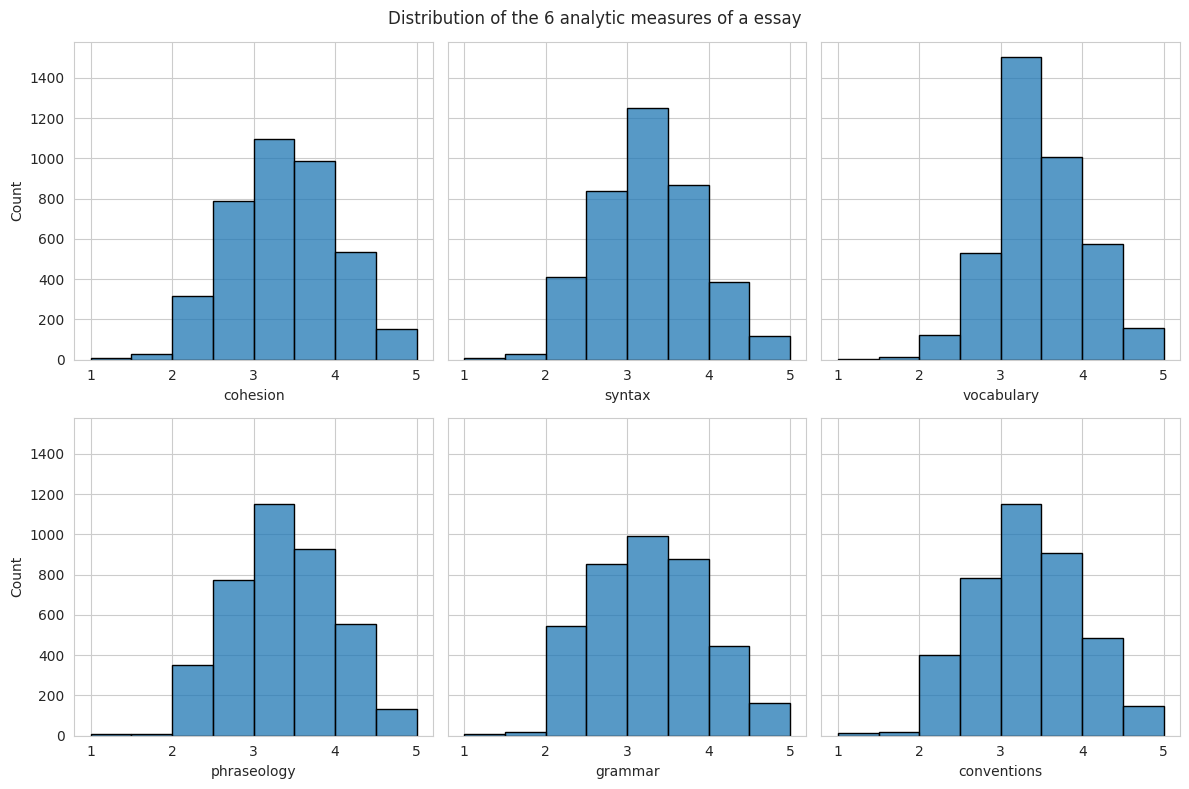

In [7]:
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(12, 8))

for i, c in enumerate(y.columns):
    sns.histplot(y[c], ax=axes[i//3, i%3], bins=8, edgecolor='k')

fig.suptitle("Distribution of the 6 analytic measures of a essay")
plt.tight_layout()
plt.show()

In [85]:
def get_metrics(y1, p1, y2, p2, fold, model, feature, target):
    return np.round(pd.DataFrame([{
        "Training RMSE": mean_squared_error(y1, p1, squared=False),
        "Testing RMSE": mean_squared_error(y2, p2, squared=False),
        "Training MAE": mean_absolute_error(y1, p1),
        "Testing MAE": mean_absolute_error(y2, p2),
        "target": target.capitalize(),
        "Fold #": fold,
        "Feature": feature,
        "Model": model
    }]), 4)

In [112]:
def train_model(X_train, y_train, X_test, model):
    model = deepcopy(model)
    model.fit(X_train, y_train)
    
    p1 = model.predict(X_train)
    p2 = model.predict(X_test)
    return p1, p2, model

In [118]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=8, n_jobs=15),
    "SVM": SVR(),
    "XGBoost": XGBRegressor(n_estimators=50, max_depth=8, n_jobs=15)
}

In [87]:
results = []
pbar = tqdm(total=4*5*6*3 - 3*5*6)

for method in ["CountVectorizer", "Tfidf-1gram", "Tfidf-2gram", "Word2Vec"]:
    X, _ = featurize_text(df, method=method)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        X_train = X.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        for t in target_columns:
            y_train = y[t][train_index]
            y_test = y[t][test_index]

            for k, v in models.items():
                
                if method != "Word2Vec" and k == "SVM":
                    continue
                train_pred, test_pred, _ = train_model(X_train, y_train, X_test, v)
                results.append(get_metrics(y_train, train_pred, y_test, test_pred, i + 1, k, method, t))

                pbar.update()

results = pd.concat(results)

  0%|          | 0/270 [00:00<?, ?it/s]

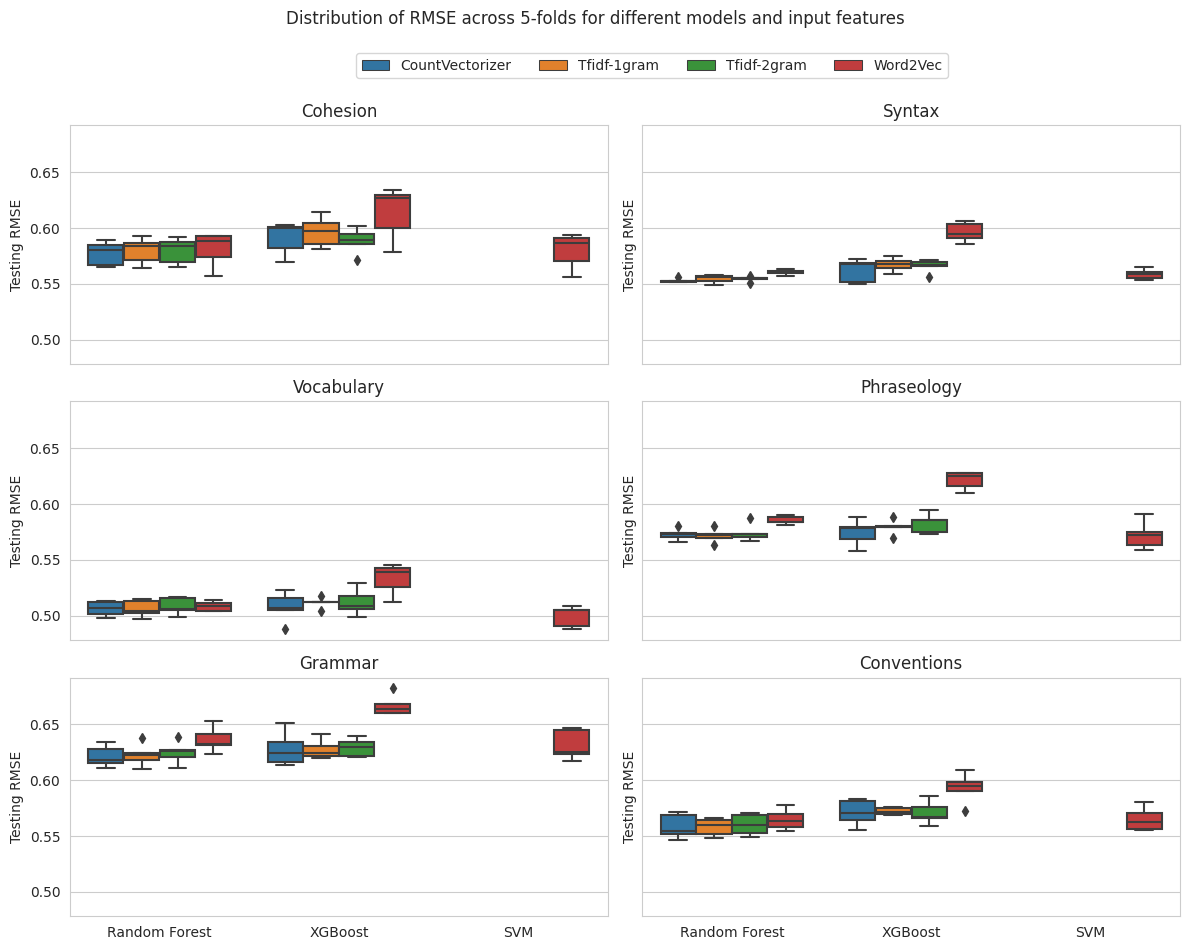

In [114]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=True, sharey=True)

for i, t in enumerate(target_columns):
    sns.boxplot(data=results[results.target == t.capitalize()],
                y="Testing RMSE", x="Model", hue="Feature", ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xlabel("")
    axes[i//2, i%2].set_title(t.capitalize())

for i in range(3):
    for j in range(2):
        axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title="", ncol=4, bbox_to_anchor=(0.8, 1.01))

fig.suptitle("Distribution of RMSE across 5-folds for different models and input features", y=1.05)

plt.tight_layout()
plt.show()

In [116]:
best_models = results.groupby(['target', 'Feature', 'Model'])['Testing RMSE', 'Testing MAE'].mean()
best_models = best_models.loc[best_models.groupby('target')['Testing RMSE'].idxmin()].reset_index()
best_models

,target,Feature,Model,Testing RMSE,Testing MAE
0,Cohesion,CountVectorizer,Random Forest,0.57732,0.46654
1,Conventions,Tfidf-1gram,Random Forest,0.55802,0.44198
2,Grammar,CountVectorizer,Random Forest,0.62130,0.50302
3,Phraseology,Tfidf-1gram,Random Forest,0.57170,0.45892
4,Syntax,CountVectorizer,Random Forest,0.55284,0.44380
5,Vocabulary,Word2Vec,SVM,0.49966,0.39316


In [127]:
model_dict = {}

for i in tqdm(range(len(best_models))):
    t = best_models.target[i].lower()
    f = best_models.Feature[i]
    m = best_models.Model[i]
    
    X, fmodel = featurize_text(df, method=f)
    X_train, X_test, y_train, y_test = train_test_split(X, y[t])
    
    scaler = StandardScaler()
    
    features = X_train.columns
    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(data=X_train, columns=features)
    
    X_test = scaler.transform(X_test)
    X_test = pd.DataFrame(data=X_test, columns=features)
    
    _, _, model = train_model(X_train, y_train, X_test, models[m])
    
    model_dict[t] = (fmodel, scaler, model)


with open("../data/best_models.p", "wb") as f:
    pickle.dump(model_dict, f)

  0%|          | 0/6 [00:00<?, ?it/s]

In [138]:
# mm = model_dict['cohesion'][-1]
# xx = pd.DataFrame(data=np.transpose([mm.feature_names_in_, mm.feature_importances_]),
#                   columns=["Feature", "Importance"])
# xx = xx.sort_values(by="Importance", ascending=False)

# plt.figure(figsize=(12, 5))
# sns.barplot(data=xx.head(20), x="Feature", y="Importance")

# plt.xticks(rotation=45)
# plt.show()